In [31]:
import sys
!{sys.executable} -m pip install SQLAlchemy pandas pymysql scipy

     |████████████████████████████████| 34.5 MB 25.0 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
import pymysql
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text
import numpy as np
from sqlite3 import OperationalError

# engine = create_engine('mysql+pymysql://root:root@db/matches')
coordinates_kills = pd.read_csv("/content/50000_rows_matches_kills.csv")
coordinates_kills['map'].value_counts()

In [4]:
'''
query = 'SELECT * FROM maps'

with engine.begin() as conn:
    maps = pd.read_sql_query(sql=text(query), con=conn)
maps'''
# one hot encoding for the maps
maps_cols = pd.get_dummies(coordinates_kills.map, dtype=bool)
# 1 when the killer was on attack, 0 when the killer was on defense
killer_atk_col = pd.get_dummies(coordinates_kills.k_atk_def, dtype=bool)["atk"]
killer_atk_col

uuid displayName  \
0  7eaecc1b-4337-bbf6-6ab9-04b8f06b3319      Ascent   
1  d960549e-485c-e861-8d71-aa9d1aed12a2       Split   
2  b529448b-4d60-346e-e89e-00a4c527a405    Fracture   
3  2c9d57ec-4431-9c5e-2939-8f9ef6dd5cba        Bind   
4  2fb9a4fd-47b8-4e7d-a969-74b4046ebd53      Breeze   
5  2fe4ed3a-450a-948b-6d6b-e89a78e680a9       Lotus   
6  fd267378-4d1d-484f-ff52-77821ed10dc2       Pearl   
7  e2ad5c54-4114-a870-9641-8ea21279579a      Icebox   
8  2bee0dc9-4ffe-519b-1cbd-7fbe763a6047       Haven   

                                         displayIcon  \
0  https://media.valorant-api.com/maps/7eaecc1b-4...   
1  https://media.valorant-api.com/maps/d960549e-4...   
2  https://media.valorant-api.com/maps/b529448b-4...   
3  https://media.valorant-api.com/maps/2c9d57ec-4...   
4  https://media.valorant-api.com/maps/2fb9a4fd-4...   
5  https://media.valorant-api.com/maps/2fe4ed3a-4...   
6  https://media.valorant-api.com/maps/fd267378-4...   
7  https://media.valorant-api.com/maps/e2ad5c54-4...   
8  https://media.valorant-api.com/maps/2bee0dc9-4...   

                       mapUrl  xMultiplier  yMultiplier  xScalarToAdd  \
0    /Game/Maps/Ascent/Ascent     0.000070    -0.000070      0.813895   
1    /Game/Maps/Bonsai/Bonsai     0.000078    -0.000078      0.842188   
2    /Game/Maps/Canyon/Canyon     0.000078    -0.000078      0.556952   
3  /Game/Maps/Duality/Duality     0.000059    -0.000059      0.576941   
4  /Game/Maps/Foxtrot/Foxtrot     0.000070    -0.000070      0.465123   
5          /Game/Maps/Jam/Jam     0.000072    -0.000072      0.454789   
6        /Game/Maps/Pitt/Pitt     0.000078    -0.000078      0.480469   
7        /Game/Maps/Port/Port     0.000072    -0.000072      0.460214   
8      /Game/Maps/Triad/Triad     0.000075    -0.000075      1.093450   

   yScalarToAdd  
0      0.573242  
1      0.697578  
2      1.155886  
3      0.967566  
4      0.833078  
5      0.917752  
6      0.916016  
7      0.304687  
8      0.642728

In [ ]:
'''limit = 500000
query = f'SELECT k_atk_def, map FROM kills LIMIT {limit}'

with engine.begin() as conn:
    df = pd.read_sql_query(sql=text(query), con=conn)
df.head()'''
features_df = pd.concat([coordinates_kills, maps_cols, killer_atk_col], axis=1)
features_df.head()

k_atk_def                   map
0       atk  /Game/Maps/Port/Port
1       def  /Game/Maps/Port/Port
2       def  /Game/Maps/Port/Port
3       def  /Game/Maps/Port/Port
4       atk  /Game/Maps/Port/Port

In [ ]:
'''
# one hot encoding for the maps
maps_cols = pd.get_dummies(df.map, dtype=bool)
# 1 when the killer was on attack, 0 when the killer was on defense
killer_atk_col = pd.get_dummies(df.k_atk_def, dtype=bool)["atk"]'''
'''
query = f'SELECT k_x, k_y, v_x, v_y FROM kills LIMIT {limit}'

with engine.begin() as conn:
    df = pd.read_sql_query(sql=text(query), con=conn)

features_df = pd.concat([df, maps_cols, killer_atk_col], axis=1)
features_df.head()'''
# swap k_x, k_y pair with the v_x, v_y pair 
def swap_cols(row):
    temp_k_x = row['k_x']
    row['k_x'] = row['v_x']
    row['v_x'] = temp_k_x
    # swap for y coord
    temp_k_y = row['k_y']
    row['k_y'] = row['v_y']
    row['v_y'] = temp_k_y
    return row

features_df["kill"] = True
# split the dataset in half
top_half = features_df.sample(frac = 0.5)
bottom_half = features_df.drop(top_half.index)

# In the first half, shuffle the k_x, k_y pair with the v_x, v_y pair. Also, invert the atk column.
top_half = top_half.apply(lambda row : swap_cols(row), axis=1)
top_half["atk"] = np.invert(top_half["atk"])
top_half["kill"] = np.invert(top_half["kill"])

# recombine the whole dataframe
features_df = pd.concat([top_half, bottom_half])
# shuffle the final dataframe
features_df = features_df.sample(frac=1).reset_index(drop=True)
features_df.head(n=10)

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers

# Load and preprocess the dataset
df = features_df.copy()
features = ['k_x', 'k_y','v_x', 'v_y', 'map']
X = pd.get_dummies(df[features], columns=['map']) # Convert 'map' to one-hot encoding along with other features
y = df['kill']# get kill? col
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the input features
# Helps with accuracy
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Define the model
# 1 input layer, 2 hidden layers, and 1 output layer
# Sigmoid used to get a probabilty of k killing v
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model with a custom learning rate
# Learning rate decays over time i.e after 10000 steps is reached
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
# binary cross entopy loss used since our classification is binary 
# did k kill v based on their position can be seen as true or false
optimizer = optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping to prevent overfitting and improve accuracy
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
X

k_x       k_y       v_x       v_y  /Game/Maps/Ascent/Ascent  \
0  0.767654  0.272817  0.627326  0.236673                     False   
1  0.677654  0.277929  0.613502  0.225009                     False   
2  0.702350  0.276705  0.669014  0.215649                     False   
3  0.631070  0.105993  0.567782  0.226665                     False   
4  0.461510  0.346401  0.560294  0.236313                     False   

   /Game/Maps/Bonsai/Bonsai  /Game/Maps/Canyon/Canyon  /Game/Maps/Jam/Jam  \
0                     False                     False               False   
1                     False                     False               False   
2                     False                     False               False   
3                     False                     False               False   
4                     False                     False               False   

   /Game/Maps/Pitt/Pitt  /Game/Maps/Port/Port  /Game/Maps/Triad/Triad    atk  
0                 False                  True                   False   True  
1                 False                  True                   False  False  
2                 False                  True                   False  False  
3                 False                  True                   False  False  
4                 False                  True                   False   True

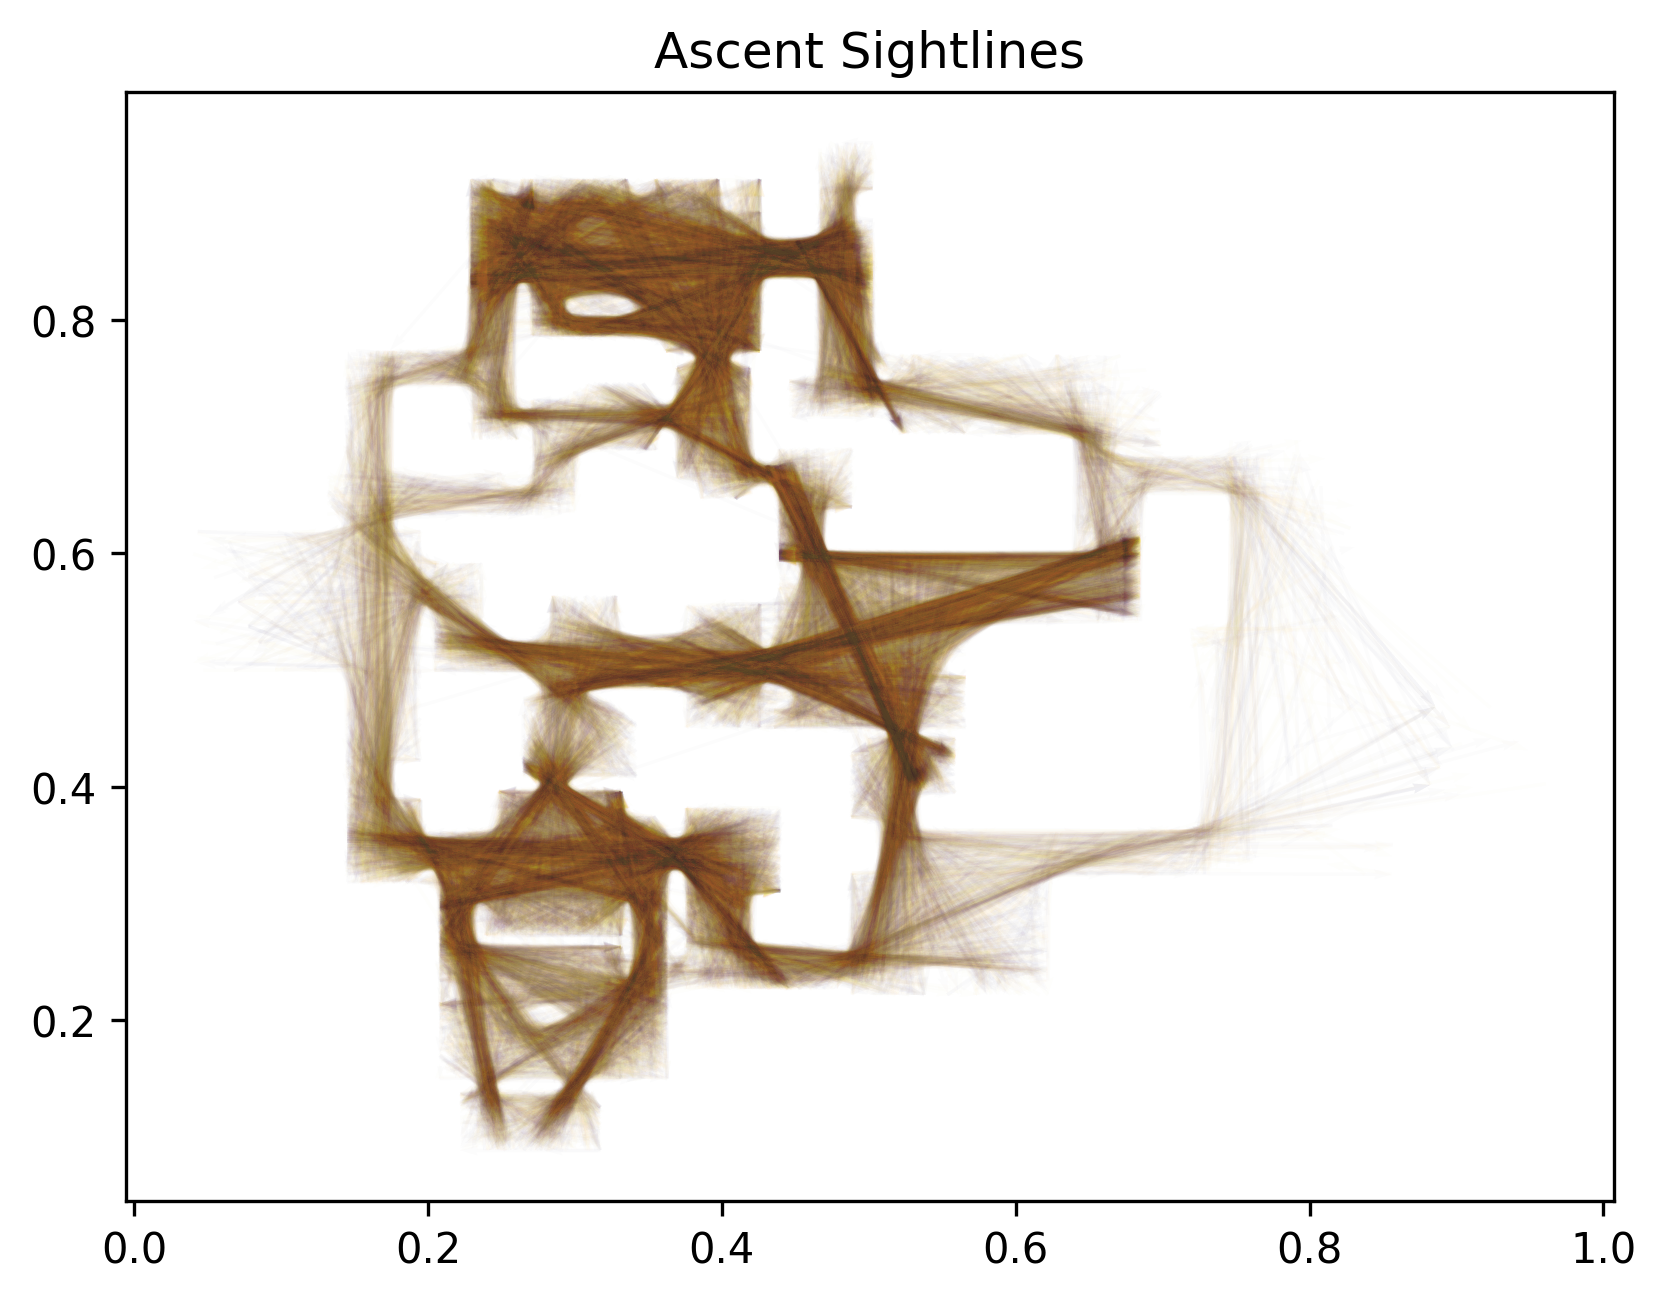

In [ ]:
import matplotlib.pyplot as plt
import scipy

ascent_df = features_df.loc[features_df['/Game/Maps/Ascent/Ascent'] == True]

plt.figure(dpi=300)
plt.quiver(ascent_df['k_x'], ascent_df['k_y'], ascent_df['v_x'] - ascent_df['k_x'], ascent_df['v_y'] - ascent_df['k_y'],
           ascent_df['atk'], units='xy', scale_units='xy', scale=1, alpha=0.01, angles='xy')
plt.title('Ascent Sightlines')
plt.show()

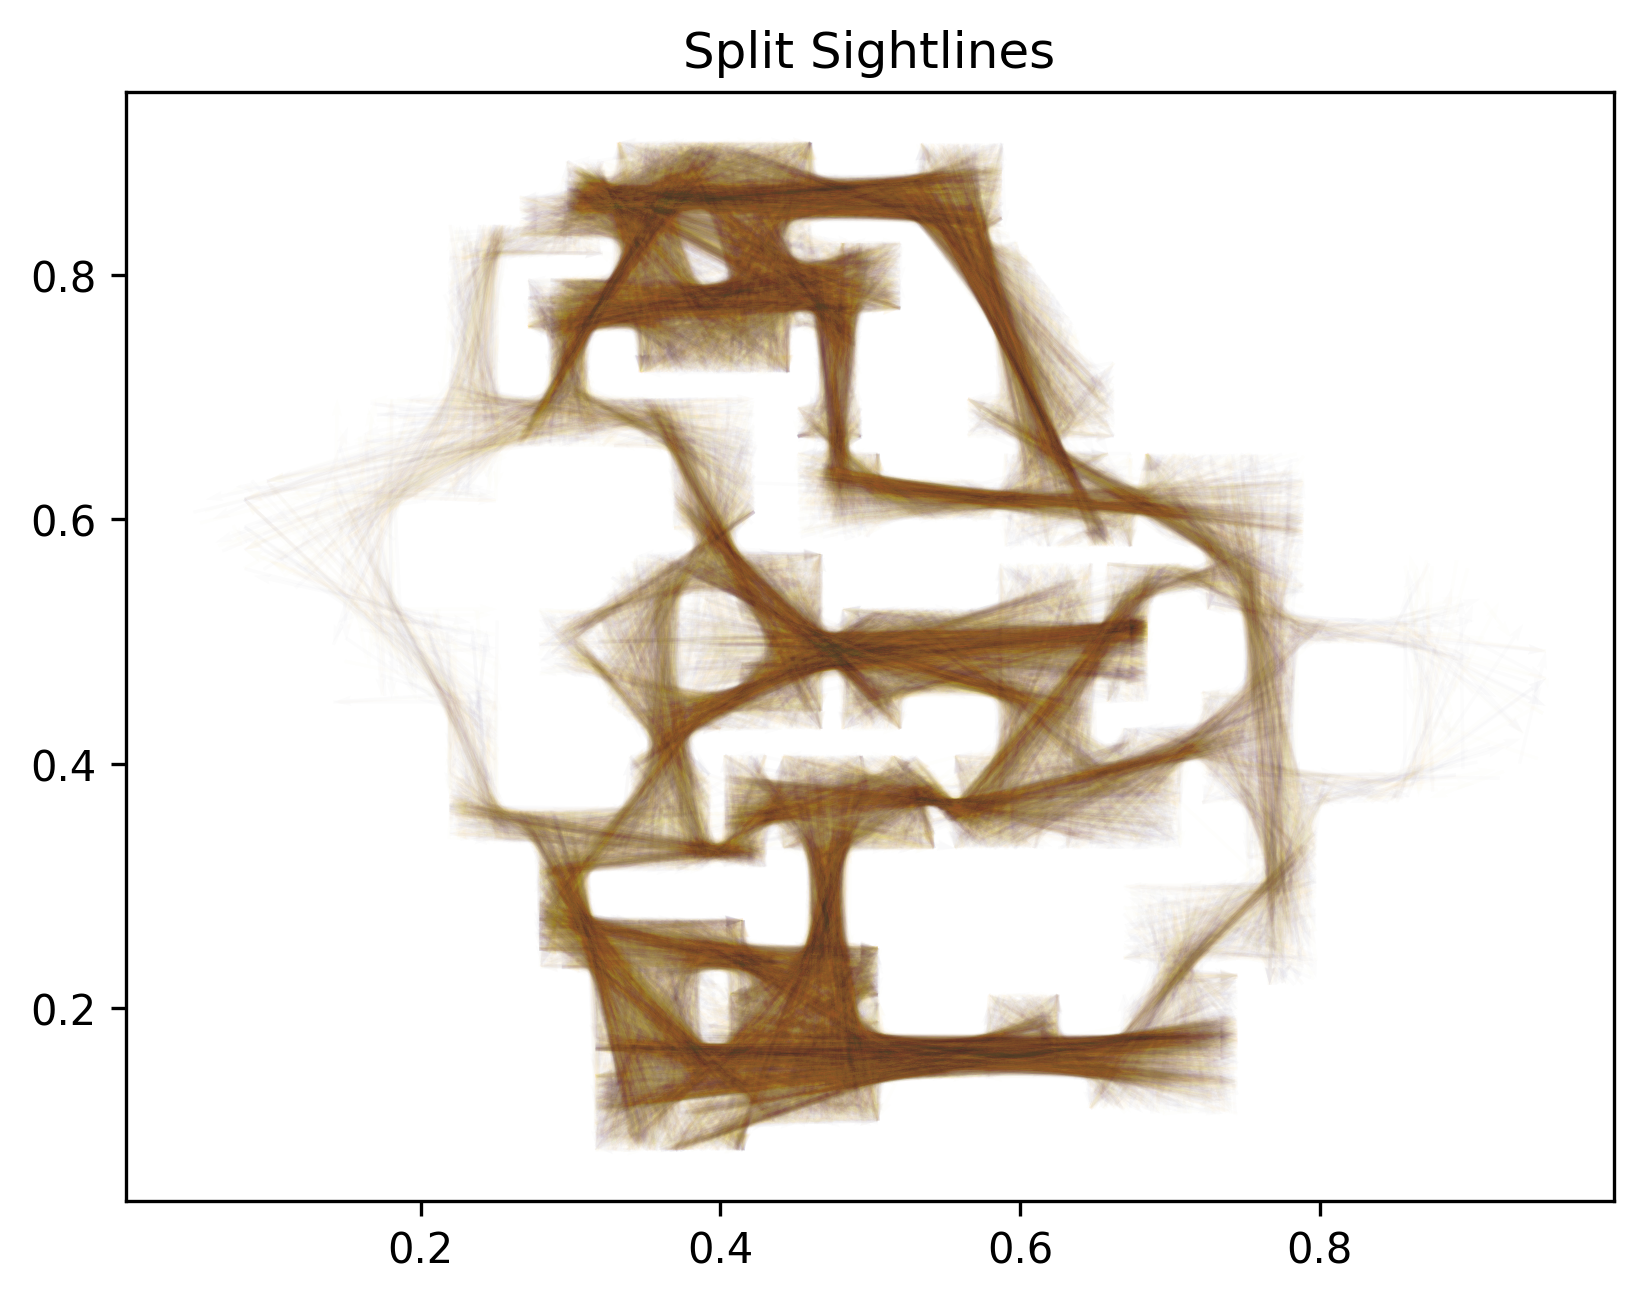

In [ ]:
haven_df = features_df.loc[features_df['/Game/Maps/Triad/Triad'] == True]

plt.figure(dpi=300)
plt.quiver(haven_df['k_x'], haven_df['k_y'], haven_df['v_x'] - haven_df['k_x'], haven_df['v_y'] - haven_df['k_y'],
           haven_df['atk'], units='xy', scale_units='xy', scale=1, alpha=0.01, angles='xy')
plt.title('Split Sightlines')
plt.show()